In [ ]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : LSTM        ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import time
import datetime
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers import Embedding
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed May 18 06:30:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Remove comma from tokenize to make one string
df = df.copy()
df['cleanReview'] = df['cleanReview'].apply(lambda x: ','.join(map(str, x)))
df.loc[:,'cleanReview'] =  df['cleanReview'].str.replace(r',', ' ', regex=True)
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,wonderful place get lunch staff friendly effic...
3,5.0,dedicated loving memory gary feldman greatest ...
5,5.0,love place everything menu delicious like tuna...
7,5.0,truely hidden gem place greatest buffalo chick...
9,5.0,seriously great fresh fantastic food spot pric...


In [ ]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

# Convert data types
df['stars_reviews'] = df['stars_reviews'].astype('int')

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0                770743
1                770743
dtype: int64

In [ ]:
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(829874, 2)

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [ ]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.1, stratify=label,
                                                    random_state=42)

In [ ]:
class KerasTokenizer(object):
    '''
    Fit and convert text to sequences for use in a Keras model.
    num_words = max number of words 
    maxlen  = max length of sequences
    '''
    def __init__(self, num_words=100000, maxlen=500):
        self.tokenizer = text.Tokenizer(num_words=num_words)
        self.maxlen = maxlen
        
    def fit(self, X, y):
        self.tokenizer.fit_on_texts(X)
        return self
        
    def transform(self, X):
        return sequence.pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen=self.maxlen)
    

In [ ]:
km  = Pipeline([('Keras Tokenizer', KerasTokenizer(num_words=100000, maxlen=500))]) 

In [ ]:
X_train = km.fit_transform(X_train)
X_test = km.fit_transform(X_test)

In [ ]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/DL/LSTM/ReviewStars/Models/

/content/drive/MyDrive/Yelp_Reviews/DL/LSTM/ReviewStars/Models


In [ ]:
import datetime
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')


In [ ]:
# Set up callbacks
filepath = 'LSTM_weights_only_b256_balancedSP.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='val_accuracy', 
                                  save_best_only = True, mode='max'), 
                  tensorboard_callback]

In [ ]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(500,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.0))(x) 
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
                    batch_size=256, callbacks=callbacks_list)

Epoch 1/10
2918/2918 [==============================] - 696s 235ms/step - loss: 0.0979 - accuracy: 0.9627 - val_loss: 0.4522 - val_accuracy: 0.8236
Epoch 2/10
2918/2918 [==============================] - 683s 234ms/step - loss: 0.0591 - accuracy: 0.9788 - val_loss: 0.4727 - val_accuracy: 0.8246
Epoch 3/10
2918/2918 [==============================] - 682s 234ms/step - loss: 0.0397 - accuracy: 0.9863 - val_loss: 0.6072 - val_accuracy: 0.8131
Epoch 4/10
2918/2918 [==============================] - 685s 235ms/step - loss: 0.0255 - accuracy: 0.9915 - val_loss: 0.6425 - val_accuracy: 0.8138


In [ ]:
# Save model
model.save('./LSTM_batch256_10epochs_balancedSP_tf.h5', save_format='tf')
5
# Load model for more training or later use
#model = tf.keras.models.load_model('./LSTM_batch256_10epochs_balancedSP_tf.h5')

# Show the model architecture
#model.summary()

5

In [ ]:
acc = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

2594/2594 [==============================] - 39s 15ms/step - loss: 0.6425 - accuracy: 0.8138
Test set
  Loss: 0.642
  Accuracy: 0.814


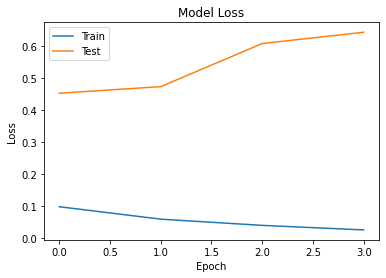

In [ ]:
# Plot loss over epochs
my_dpi = 96
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch256_balancedSP_Loss.png', dpi=my_dpi * 10,
               bbox_inches='tight')
plt.show()

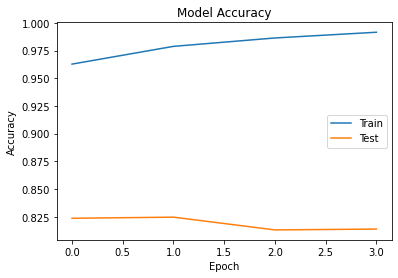

In [ ]:
# Plot accuracy over epochs
my_dpi = 96
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('LSTM_len500_batch256_balancedSP_2.png', dpi=my_dpi * 10,
               bbox_inches='tight')
plt.show()

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [ ]:
# Score model
scores = model.predict(X_test, verbose=1)

2594/2594 [==============================] - 37s 14ms/step


In [ ]:
y_pred_1d = [decode_sentiment(score) for score in scores]

In [ ]:
# Define function for constructing confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

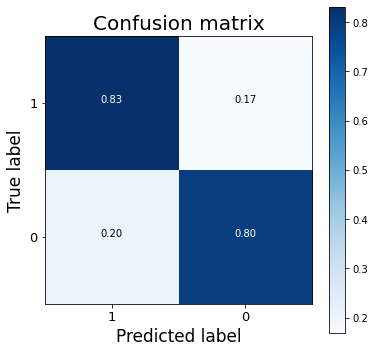

In [ ]:
my_dpi=96
cnf_matrix = confusion_matrix(y_test['stars_reviews'].tolist(), y_pred_1d) #.sentiment.to_list()
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.stars_reviews.unique(), title="Confusion matrix") #_data.sentiment
plt.savefig('LSTM_len500_batch256_balancedSP_CF.png', dpi=my_dpi * 10,
               bbox_inches='tight')
plt.show()

In [ ]:
# Classifcation score for model 
print(classification_report(y_test['stars_reviews'].tolist(), y_pred_1d))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     41494
           1       0.83      0.80      0.81     41494

    accuracy                           0.81     82988
   macro avg       0.81      0.81      0.81     82988
weighted avg       0.81      0.81      0.81     82988

